<a href="https://colab.research.google.com/github/sokldjs554/Deep-learning-Project/blob/main/%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastai duckduckgo_search nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.5 MB/s eta 0:00:00


In [29]:
import ipywidgets as widgets

from fastcore.all import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastdownload import download_url
from duckduckgo_search import DDGS

from itertools import islice
from time import time, sleep

In [3]:
searches = ['bicycle', 'motorcycle']

path = Path('vehicles')

In [11]:
def search_images(term, max_images = 40) :
  print(f"Searching for '{term}'")
  ddgs_images = DDGS().images(
      term,
      type_image = "photo",
      license_image = "Public"
  )
  limited_images = list(islice(ddgs_images, max_images))
  return L(limited_images).itemgot('image')

Searching for 'bicycle'


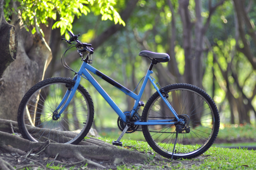

Searching for 'motorcycle'


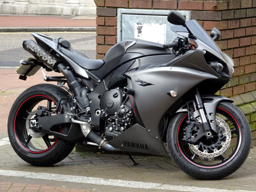

In [13]:
for o in searches :
  urls = search_images(o, max_images = 1)
  dest = f"{o}.jpg"
  download_url(urls[0], dest, show_progress = False)
  im = Image.open(dest)
  display(im.to_thumb(256))

In [19]:
for o in searches :
  dest = (path/o)
  dest.mkdir(exist_ok = True, parents = True)

  download_images(dest, urls = search_images(f" {o} "))
  sleep(10)

  download_images(dest, urls = search_images(f"{o} in the park"))
  sleep(10)

  download_images(dest, urls = search_images(f"{o} in the forest"))
  sleep(10)

  resize_images(dest, max_size = 400, dest = dest)

Searching for ' bicycle '
Searching for 'bicycle in the park'
Searching for 'bicycle in the forest'
Searching for ' motorcycle '
Searching for 'motorcycle in the park'
Searching for 'motorcycle in the forest'


In [20]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

0

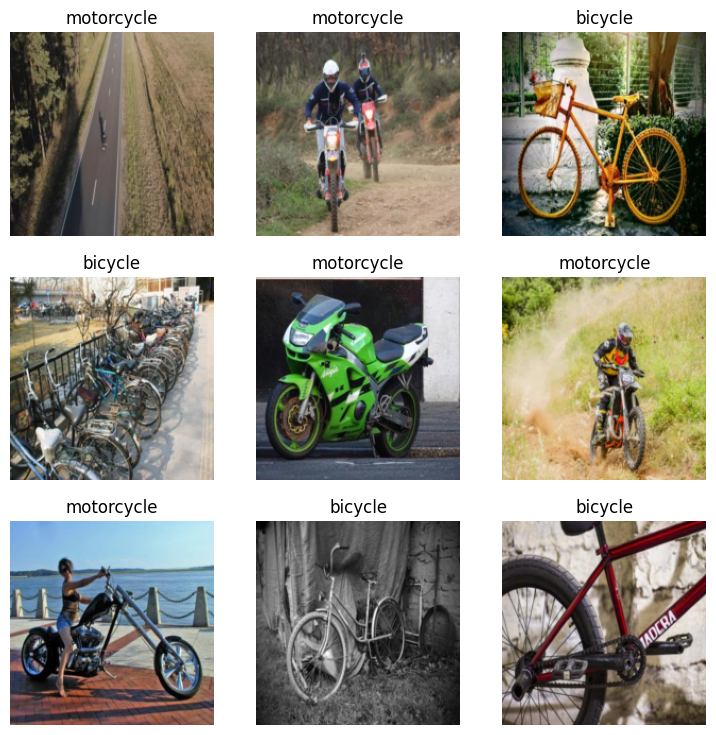

In [21]:
#모델 학습
dls = DataBlock(
    blocks = (ImageBlock, CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42),
    get_y = parent_label,
    item_tfms = [Resize(192, method = 'squish')]
).dataloaders(path, bs = 32)

dls.show_batch(max_n = 9)

In [23]:
learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(5)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 102MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.020884,1.341357,0.446809,00:02


epoch,train_loss,valid_loss,error_rate,time
0,0.380666,0.162582,0.063830,00:01
1,0.240266,0.311148,0.085106,00:01
2,0.176166,0.486877,0.127660,00:01
3,0.138190,0.537861,0.127660,00:01
4,0.119019,0.530450,0.127660,00:01


prediction : bicycle
probability : 0.9956


<Axes: >

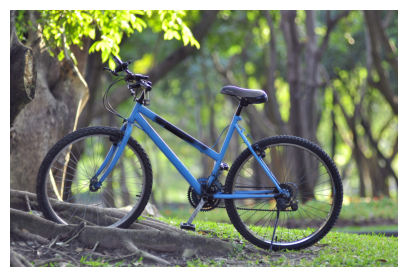

In [24]:
#Inference(추론)
im = PILImage.create('bicycle.jpg')

pred, pred_idx, probs = learn.predict(im)

print(f"prediction : {pred}")
print(f"probability : {probs[pred_idx] :.04f}")
im.show()

prediction : motorcycle
probability : 0.9994


<Axes: >

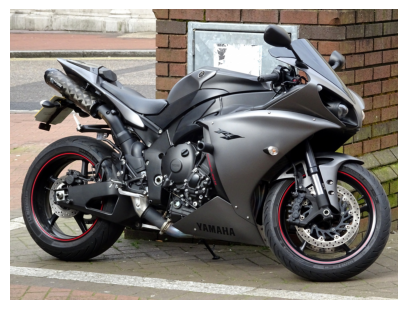

In [25]:
im = PILImage.create('motorcycle.jpg')

pred, pred_idx, probs = learn.predict(im)

print(f"prediction : {pred}")
print(f"probability : {probs[pred_idx] :.04f}")
im.show()

In [32]:
#Widget
btn_upload = widgets.FileUpload(
    accept = 'image/*',
    multiple = False
)
btn_run = widgets.Button(description = 'Classify')
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [34]:
def on_click_classify(image) :
  img = PILImage.create(btn_upload.data[-1])
  out_pl.clear_output()
  with out_pl : display(img.to_thumb(256, 256))
  pred, pred_idx, probs = learn.predict(img)
  lbl_pred.value = f"pred : {pred} : prob : {probs[pred_idx]:.04f}"

btn_run.on_click(on_click_classify)

In [36]:
VBox([widgets.Label('bicycle or motorcycle?'), btn_upload, btn_run, out_pl, lbl_pred])